In [1]:
import os
import random
import numpy as np

import torch
import torch.utils.data
import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from imantics import Mask, Polygons


label_dict = {
    0:'',
    1:'mask',
    2:'wear_male_under25',
    3:'wear_male_over25',
    4:'wear_female_under25',
    5:'wear_female_over25',
    6:'incorrect_male_under25',
    7:'incorrect_male_over25',
    8:'incorrect_female_under25',
    9:'incorrect_female_over25',
    10:'NotWear_male_under25',
    11:'NotWear_male_over25',
    12:'NotWear_female_under25',
    13:'NotWear_female_over25',
}


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def get_train_transform(height = 512, width = 512):
    return A.Compose([
                    A.Resize(height, width),
                    ToTensorV2()
                    ])


def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR).astype(np.float32)
    image /= 255
    return image


torch.Size([3, 512, 512])

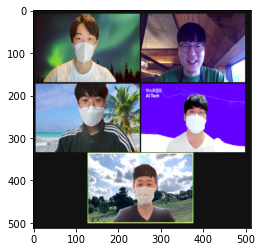

In [2]:

path = 'us.png'
test_paths = list(map(lambda x:os.path.join('data/eval/images', x), os.listdir('data/eval/images')))
random.shuffle(test_paths)

tfm = get_train_transform()
# image = load_image(test_paths[0])
image = load_image(path)
image = tfm(image=image)['image']
plt.imshow(image.permute(1,2,0))
image.shape


In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
#     model.backbone = mobilenet.features

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [4]:
def post_processing(prediction, threshold = 0.5):
    label_dict = {
        0:'None',
        1:'mask',
        2:'wear_male_under25',
        3:'wear_male_over25',
        4:'wear_female_under25',
        5:'wear_female_over25',
        6:'incorrect_male_under25',
        7:'incorrect_male_over25',
        8:'incorrect_female_under25',
        9:'incorrect_female_over25',
        10:'NotWear_male_under25',
        11:'NotWear_male_over25',
        12:'NotWear_female_under25',
        13:'NotWear_female_over25',
    }

    result = {
        'number':0,
        'bboxes':{        
        },
        'labels':{
        },
        'segmentations':{
        },
        'masks':{
            
        }
    }
    
    for idx, (box, label, score, mask) in enumerate(zip(*prediction[0].values()), start=1):
        if label == 1:
            mask = (mask.detach().cpu().numpy() > 0.3).squeeze(0)
        else:
            mask = (mask.detach().cpu().numpy() > 0.5).squeeze(0)
        polygons = Mask(mask).polygons()
        
        if score < threshold or polygons.points == []:
            result['number'] = idx-1
            break
        result['bboxes'].update({idx:box.detach().cpu().numpy().tolist()})
        result['labels'].update({idx:label_dict[label.detach().cpu().numpy().tolist()]})
#         result['segmentations'].update({idx:polygons.points[0].tolist()})
        result['masks'].update({idx:mask})
    else:
        result['number'] = idx
#     print(result)
    return result


In [5]:
label_dict = {
        0:'None',
        1:'mask',
        2:'wear_male_under25',
        3:'wear_male_over25',
        4:'wear_female_under25',
        5:'wear_female_over25',
        6:'incorrect_male_under25',
        7:'incorrect_male_over25',
        8:'incorrect_female_under25',
        9:'incorrect_female_over25',
        10:'NotWear_male_under25',
        11:'NotWear_male_over25',
        12:'NotWear_female_under25',
        13:'NotWear_female_over25',
    }

label_revert = {value:key for key, value in label_dict.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


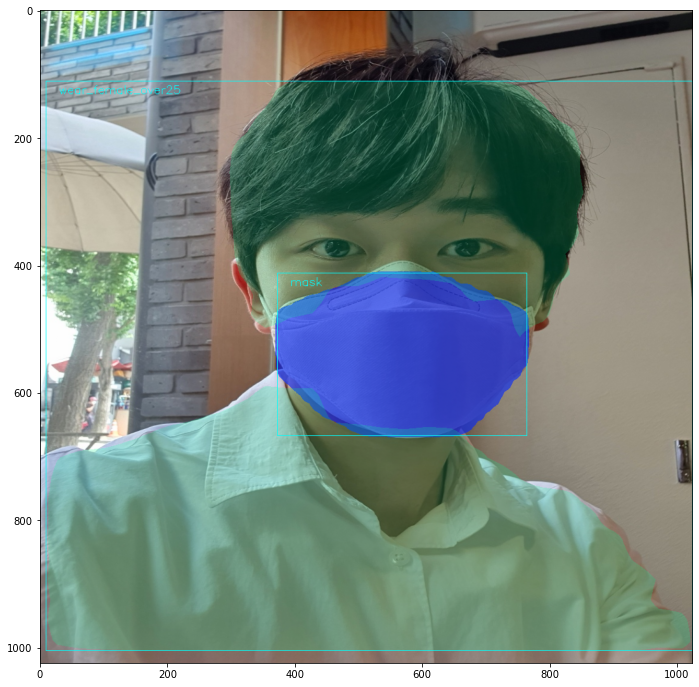

dict_values(['mask', 'wear_female_over25'])


In [124]:
import colorsys
import random


def get_train_transform(height = 224, width = 224):
    return A.Compose([
                    A.Resize(height, width),
                    ToTensorV2()
                    ])

def load_image(path):
    image = cv2.imread(path).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR).astype(np.float32)
    image /= 255
    return image


def inference_image(path):
    tfm = get_train_transform(1024, 1024)
    image = load_image(path)
    image = tfm(image=image)['image']
     
    
#     device = 'cpu'
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # put the model in evaluation mode
#     model = torch.load('MaskRCNN_2_hid_64.pt')
#     model.to('cpu')
    model.to(device)
    model.eval()
    with torch.no_grad():
        
        prediction = model(image.unsqueeze(0).to(device))
        prediction = post_processing(prediction, threshold = 0.3)

    masks = prediction['masks']
    colors = random_colors(14)
    image = image.permute(1,2,0).numpy()
    
    for mask, label, box in zip(masks.values(), prediction['labels'].values(), prediction['bboxes'].values()):
        
        xmin, ymin, xmax, ymax = map(int, box)
        if label_revert[label] == 1:
            image = apply_mask(image, mask, colors[label_revert[label]], alpha=0.6)
        else:
            image = apply_mask(image, mask, colors[label_revert[label]], alpha=0.2)
        image = _draw_rectangle(image, label, xmin, ymin, xmax, ymax, colors[label_revert[label]])
    plt.imshow(image)
    plt.show()
            
    print(prediction['labels'].values())
    return prediction
    
    

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def _draw_rectangle(image, label, xmin, ymin, xmax, ymax, color):
    color = [c*255 for c in color]
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
    
    cv2.putText(image, f'{label}', (xmin+20, ymin+20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1)
    return image


plt.rcParams["figure.figsize"] = (12,12)

model = get_instance_segmentation_model(14)

model.load_state_dict(torch.load("saved/mask_rcnn_Baseline/epoch_14.pt"))

random.shuffle(test_paths)
for path in test_paths[:20]:
    path = 'JY.jpg'
    
#     path = 'rerere.jpeg'
    inference_image(path)
    break


In [ ]:
' 'map(polygons.points[0].tolist()

In [30]:
def get_train_transform(height = 224, width = 224):
    return A.Compose([
                    A.Resize(height, width),
                    ToTensorV2()
                    ])

100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


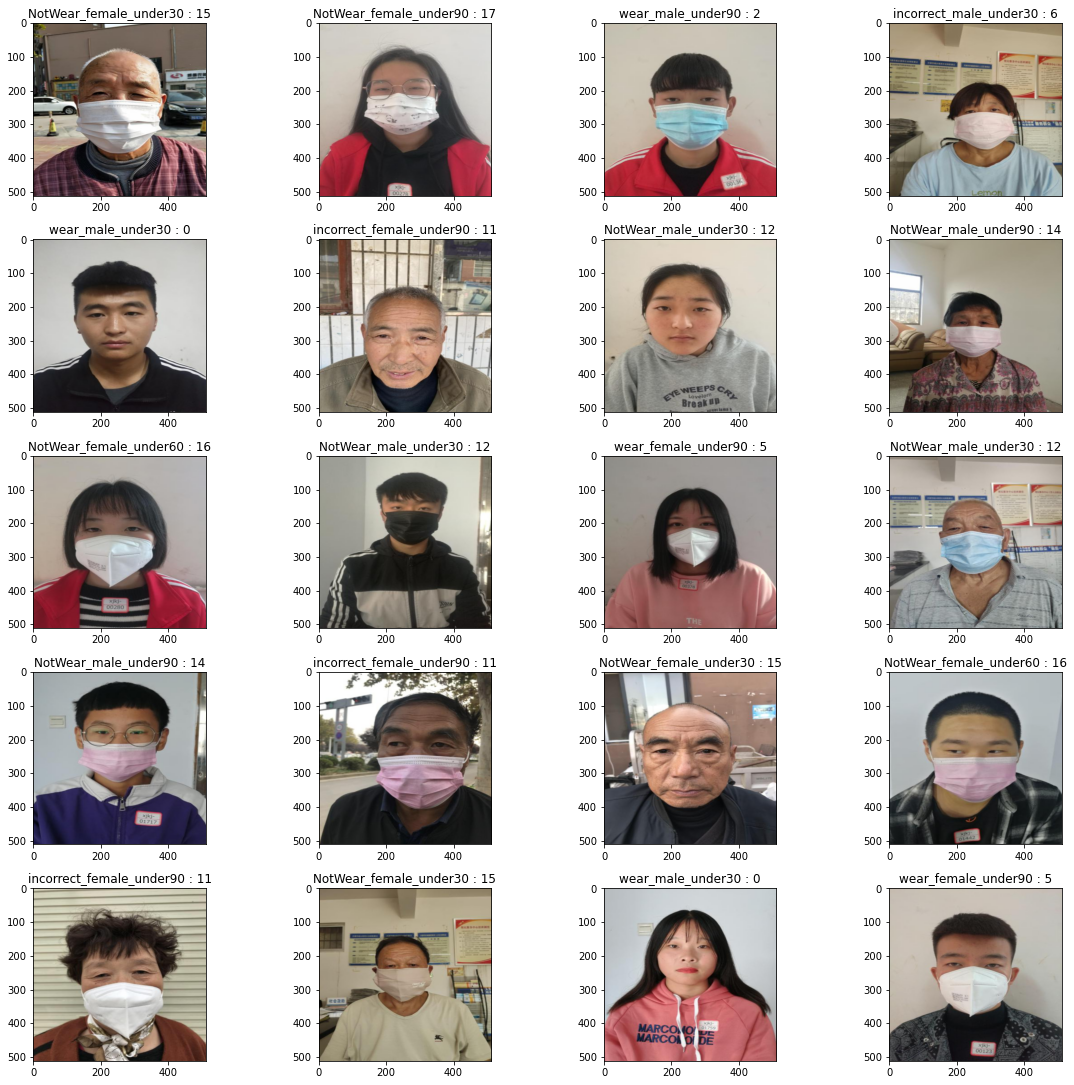

In [70]:
def get_train_transform(height = 512, width = 512):
    return A.Compose([
                    A.Resize(height, width),
                    ToTensorV2()
                    ])


def gen_img(img_paths, n, base_dir='data'):
    fig = plt.figure(figsize=(16, 60))
    
    img_paths = img_paths[:n]
    
    transform = get_train_transform()
    
    idx = 1
    
    for path in tqdm(img_paths):
        image = load_image(path)
        
        transformed = transform(image=image)
        image = transformed["image"]        
        
        title = '_'.join(path.split('/')[-2:])
        
        output = torch.argmax(model.mobilenet(image.unsqueeze(0).to('cuda')))
        
        image = image.permute(1,2,0)
        
        
        ax = fig.add_subplot(n,4,idx)
        ax.imshow(image)
#         print(output)
        ax.set_title(f'{label_dict[output.item()]} : {output.item()}')
        
        idx += 1
        
#         mask_path = path.split('.')[0] + '.png'
#         mask = load_image(mask_path)
        
#         ax = fig.add_subplot(n,4,idx)
#         ax.imshow(image+mask*255)
        
#         idx += 1
#         ax.set_title(f'{title} : mask')
    plt.tight_layout()
    plt.show()
    
random.shuffle(test_paths)
gen_img(test_paths, 20)

In [150]:
import pandas as pd
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')

In [153]:
df = train.append(val).reset_index(drop=True)
df

,id,gender,race,age,mask,class,path
0,000523,female,Asian,51,0,3,data/train/images/000523_female_Asian_51/mask4...
1,000523,female,Asian,51,2,11,data/train/images/000523_female_Asian_51/norma...
2,000523,female,Asian,51,0,3,data/train/images/000523_female_Asian_51/mask3...
3,000523,female,Asian,51,0,3,data/train/images/000523_female_Asian_51/mask1...
4,000523,female,Asian,51,1,7,data/train/images/000523_female_Asian_51/incor...
...,...,...,...,...,...,...,...
18875,000278,female,Asian,54,0,3,data/train/images/000278_female_Asian_54/mask3...
18876,000278,female,Asian,54,0,3,data/train/images/000278_female_Asian_54/mask1...
18877,000278,female,Asian,54,1,7,data/train/images/000278_female_Asian_54/incor...
18878,000278,female,Asian,54,0,3,data/train/images/000278_female_Asian_54/mask5...


In [154]:
df.to_csv('dataframe.csv',index=False)